In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import normalize
from keras.metrics import MeanIoU
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.optimizers import Adam
import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
image_directory ='/content/drive/MyDrive/railway_data/frames/'
mask_directory = '/content/drive/MyDrive/railway_data/extracted_image/'
num_images=234
size =[320,240]

image_names = glob.glob('/content/drive/MyDrive/railway_data/frames/*.jpg')
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img,cv2.IMREAD_UNCHANGED) for img in image_names_subset]
image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis = 3)
# cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_names =glob.glob('/content/drive/MyDrive/railway_data/extracted_image/*.png')
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask,0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)


print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

image_dataset = image_dataset/255.
mask_dataset = mask_dataset/255.

Image data shape is:  (234, 240, 320, 3)
Mask data shape is:  (234, 240, 320, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


# DATA AUGMENTATION






# TRAIN TEST SPLIT

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image_dataset,mask_dataset,test_size=0.20,random_state=12)

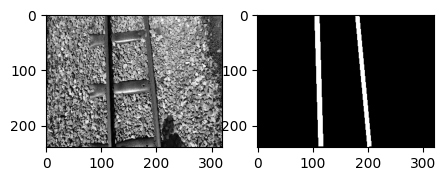

In [4]:
import random

image_number = random.randint(0,len(X_train)-1)
plt.figure(figsize=(5, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

# **Data augmentation**

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# UNET


In [5]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    # x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    # x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 8)
    s2, p2 = encoder_block(p1, 16)
    s3, p3 = encoder_block(p2, 32)

    b1 = conv_block(p3, 64) #Bridge

    d2 = decoder_block(b1, s3, 32)
    d3 = decoder_block(d2, s2, 16)
    d4 = decoder_block(d3, s1, 8)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(240, 320, 3)


In [8]:
model = build_unet(input_shape, n_classes=1)

sigmoid


In [9]:
augmentation_args = dict(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)


In [10]:
image_datagen = ImageDataGenerator(**augmentation_args)
mask_datagen = ImageDataGenerator(**augmentation_args)


batch_size = 10
seed = 10

image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

# Combine the image and mask generators into a single generator
train_generator = zip(image_generator, mask_generator)


In [12]:
from keras import backend as K
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])


# model.fit(train_generator, steps_per_epoch=5, epochs=25)
history = model.fit(train_generator, steps_per_epoch=15,verbose=1,epochs=25, shuffle=False)


Epoch 1/25
15/15 [==============================] - 34s 573ms/step - loss: 0.6811 - f1_score: 0.0807
Epoch 2/25
15/15 [==============================] - 4s 275ms/step - loss: 0.2955 - f1_score: 3.4378e-04
Epoch 3/25
15/15 [==============================] - 3s 230ms/step - loss: 0.2526 - f1_score: 4.0604e-06
Epoch 4/25
15/15 [==============================] - 4s 279ms/step - loss: 0.2254 - f1_score: 0.0000e+00
Epoch 5/25
15/15 [==============================] - 6s 369ms/step - loss: 0.1897 - f1_score: 0.0000e+00
Epoch 6/25
15/15 [==============================] - 3s 232ms/step - loss: 0.1453 - f1_score: 0.0000e+00
Epoch 7/25
15/15 [==============================] - 3s 229ms/step - loss: 0.1224 - f1_score: 6.1367e-04
Epoch 8/25
15/15 [==============================] - 4s 267ms/step - loss: 0.1104 - f1_score: 0.0461
Epoch 9/25
15/15 [==============================] - 6s 375ms/step - loss: 0.0982 - f1_score: 0.4217
Epoch 10/25
15/15 [==============================] - 3s 233ms/step - loss: 

2/2 [==============================] - 2s 560ms/step


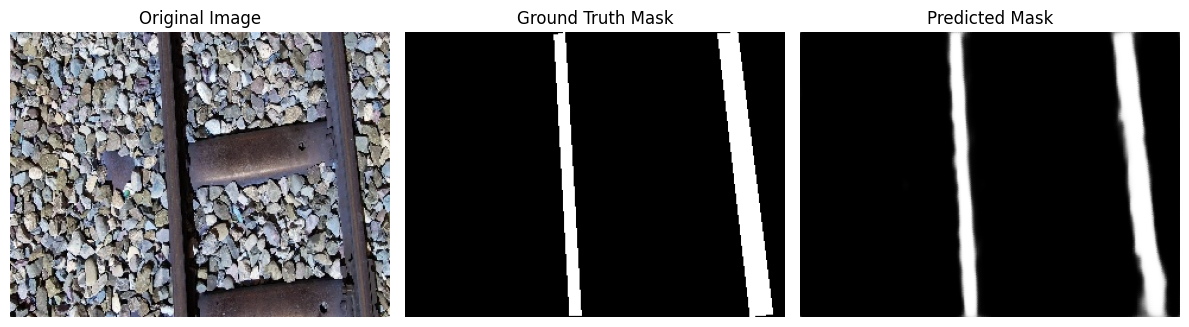

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a trained U-Net model named 'model'
predictions = model.predict(X_test)

# Choose a specific test sample and its corresponding ground truth mask
sample_index = 4  # Choose the index of the sample you want to visualize
test_sample = X_test[sample_index]
ground_truth_mask = y_test[sample_index]
predicted_mask = predictions[sample_index]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_sample)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from keras import backend as K


# def IOU(ytrue, ypred):
#   T=K.flatten(ytrue)
#   P=K.flatten(ypred)
#   intersection = K.sum(T*P)
#   IOU = (intersection+1.0)/ (K.sum(T)+K.sum(P)-intersection+1.0)
#   return IOU


# def IOU_loss(ytrue,ypred):
#   return -IOU(ytrue,ypred)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

# Usage in model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])


Data Augmentation

In [ ]:
seed=10
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     brightness_range=(0.1, 0.9),
                     zoom_range=[0.7,1.7],
                     horizontal_flip=True,
                     fill_mode='reflect',
                     cval =190
)

mask_data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=[0.7,1.7],
                     horizontal_flip=True,
                     fill_mode='reflect',
                     cval = 190,
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                    ) #Binarize the output again.

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)


mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)


def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)



In [ ]:

batch_size = 16
steps_per_epoch = 3*(len(X_train))//batch_size
model.fit(my_generator, steps_per_epoch=steps_per_epoch, epochs=10, validation_data=validation_datagen, validation_steps=10)


Epoch 1/10
35/35 [==============================] - 64s 1s/step - loss: 0.6861 - f1_score: 0.0000e+00 - val_loss: 0.6787 - val_f1_score: 0.0000e+00
Epoch 2/10
35/35 [==============================] - 38s 1s/step - loss: 0.6719 - f1_score: 0.0000e+00 - val_loss: 0.6645 - val_f1_score: 0.0000e+00
Epoch 3/10
35/35 [==============================] - 39s 1s/step - loss: 0.6581 - f1_score: 0.0000e+00 - val_loss: 0.6511 - val_f1_score: 0.0000e+00
Epoch 4/10
35/35 [==============================] - 39s 1s/step - loss: 0.6448 - f1_score: 0.0000e+00 - val_loss: 0.6379 - val_f1_score: 0.0000e+00
Epoch 5/10
35/35 [==============================] - 38s 1s/step - loss: 0.6318 - f1_score: 0.0000e+00 - val_loss: 0.6254 - val_f1_score: 0.0000e+00
Epoch 6/10
35/35 [==============================] - 38s 1s/step - loss: 0.6193 - f1_score: 0.0000e+00 - val_loss: 0.6130 - val_f1_score: 0.0000e+00
Epoch 7/10
35/35 [==============================] - 38s 1s/step - loss: 0.6074 - f1_score: 0.0000e+00 - val_loss

In [ ]:
augmented_test_images = image_data_generator.flow(X_test)
augmented_test_masks = mask_data_generator.flow(y_test)


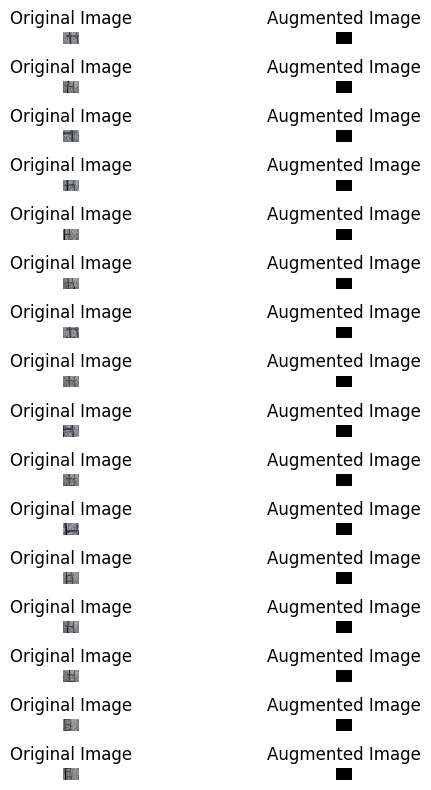

In [ ]:
import matplotlib.pyplot as plt
num_samples = 16

# Generate augmented images and masks
augmented_images = image_data_generator.flow(X_train, seed=seed, batch_size=num_samples).next()
augmented_masks = mask_data_generator.flow(y_train, seed=seed, batch_size=num_samples).next()

# Plot original and augmented images
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(8, 8))
for i in range(num_samples):
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(augmented_images[i])
    axes[i, 1].set_title('Augmented Image')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


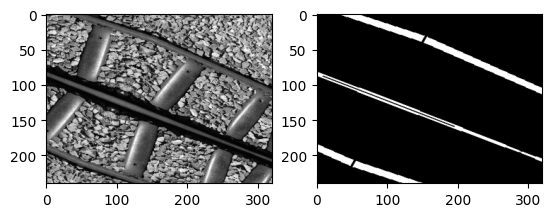

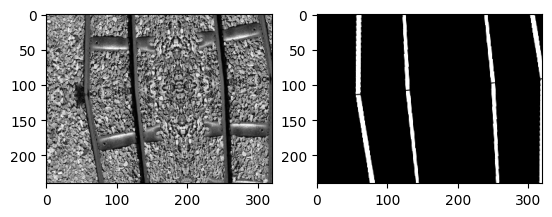

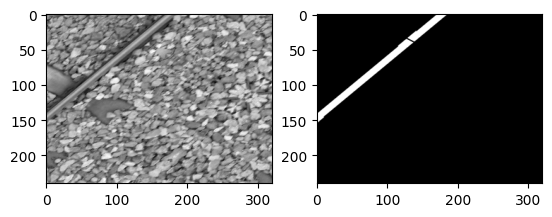

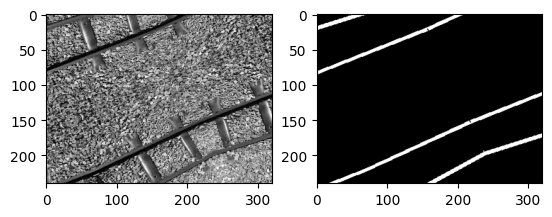

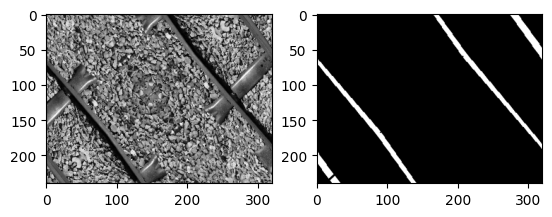

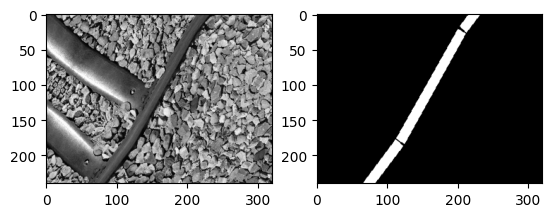

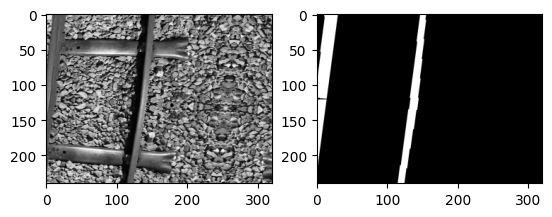

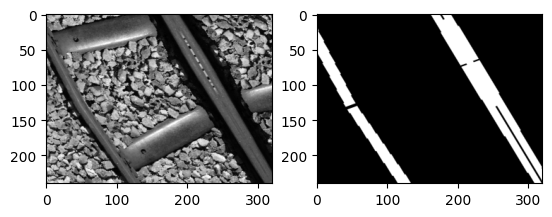

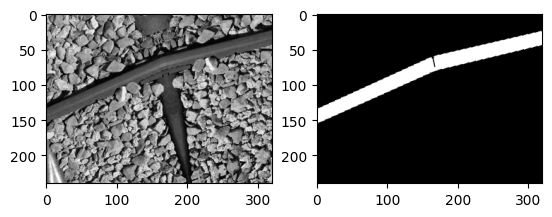

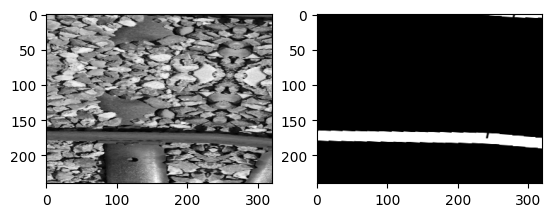

In [ ]:

x = image_generator.next()
y = mask_generator.next()
for i in range(0,10):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap= 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()


In [ ]:



# history = model.fit(X_train, y_train,batch_size =5,validation_split=0.2,verbose=1,epochs=25, shuffle=False)
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=steps_per_epoch, epochs=20)

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.2265 - f1_score: 0.0000e+00

KeyboardInterrupt: ignored

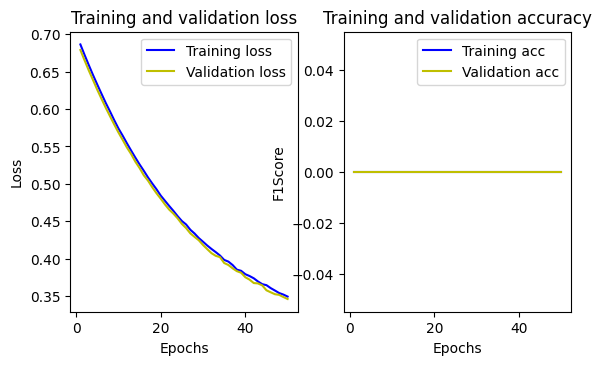

In [ ]:
# plotting loss and acc
loss = augmentedmodel.history['loss']
val_loss = augmentedmodel.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure(figsize=(10, 8))
plt.subplot(231)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')



plt.subplot(232)
f1_score = augmentedmodel.history['f1_score']
val_f1_score = augmentedmodel.history['val_f1_score']
plt.plot(epochs, f1_score, 'b', label='Training acc')
plt.plot(epochs, val_f1_score, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.legend(loc='best')
plt.show()

# METRICS and LOSSES

In [ ]:
history = model.fit(X_train, y_train,batch_size =5,validation_split=0.2,verbose=1,epochs=25, shuffle=False)

Epoch 1/25
30/30 [==============================] - 25s 118ms/step - loss: 0.4170 - f1_score: 0.0064 - val_loss: 0.2406 - val_f1_score: 0.0000e+00
Epoch 2/25
30/30 [==============================] - 1s 30ms/step - loss: 0.2144 - f1_score: 0.0000e+00 - val_loss: 0.1866 - val_f1_score: 0.0000e+00
Epoch 3/25
30/30 [==============================] - 1s 31ms/step - loss: 0.1374 - f1_score: 1.7081e-04 - val_loss: 0.1071 - val_f1_score: 0.0048
Epoch 4/25
30/30 [==============================] - 1s 33ms/step - loss: 0.0790 - f1_score: 0.6887 - val_loss: 0.0491 - val_f1_score: 0.8794
Epoch 5/25
30/30 [==============================] - 1s 33ms/step - loss: 0.0410 - f1_score: 0.8947 - val_loss: 0.0392 - val_f1_score: 0.9058
Epoch 6/25
30/30 [==============================] - 1s 34ms/step - loss: 0.0357 - f1_score: 0.9073 - val_loss: 0.0383 - val_f1_score: 0.9053
Epoch 7/25
30/30 [==============================] - 1s 35ms/step - loss: 0.0339 - f1_score: 0.9109 - val_loss: 0.0356 - val_f1_score: 0.

In [ ]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 38ms/step - loss: 0.0335 - f1_score: 0.9137


[0.033455148339271545, 0.913692057132721]

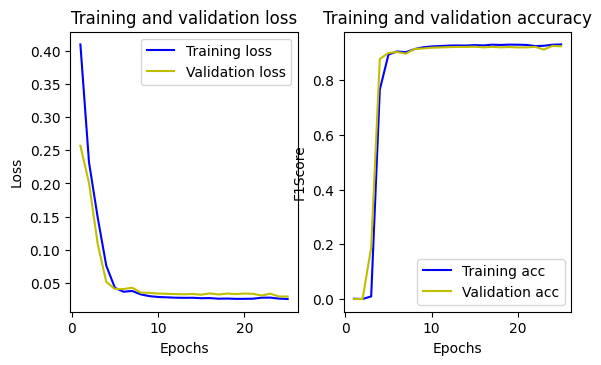

In [ ]:
# plotting loss and acc
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure(figsize=(10, 8))
plt.subplot(231)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')



plt.subplot(232)
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']
plt.plot(epochs, f1_score, 'b', label='Training acc')
plt.plot(epochs, val_f1_score, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.legend(loc='best')
plt.show()



# Inference on unet model


In [ ]:
y_pred=model.predict(X_test)


2/2 [==============================] - 3s 972ms/step


(1, 240, 320, 3)
1/1 [==============================] - 0s 363ms/step
(240, 320)


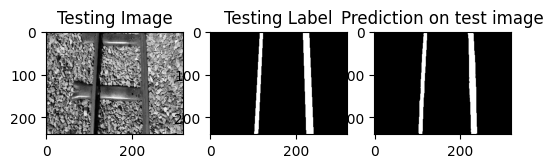

In [ ]:
import random

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)


plt.figure(figsize=(6, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/railway_data/saved_models/model1.hdf5')
#Loading saved model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/railway_data/saved_models/model1.hdf5', compile=False)


# QUANTIZATION

In [ ]:
#model----> quantization------>fine tuning of quantized model-------.tflite conversion

In [ ]:
#Quantization
!pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)
#Fine Tuning of Quantized model
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1
q_aware_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])
X_train_subset=X_train[:100]
y_train_subset=y_train[:100]
q_aware_model.fit(X_train_subset,y_train_subset,batch_size=10,epochs=1,verbose=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


10/10 [==============================] - 11s 76ms/step - loss: 0.0332 - f1_score: 0.9258


In [ ]:
q_aware_model.save('/content/drive/MyDrive/railway_data/saved_models/model2.hdf5')

In [ ]:
# pruning and weight sharing
#Layer fusion

prediction on quantized model

In [ ]:
q_aware_model.evaluate(X_test,y_test)

2/2 [==============================] - 1s 46ms/step - loss: 0.0371 - f1_score: 0.9106


[0.03709030896425247, 0.9106236696243286]

In [ ]:
# Onnx format conversion
!pip install tf2onnx

import tf2onnx.convert
import onnx

#Load The saved model
from keras.models import load_model
import tensorflow_model_optimization as tfmot

with tfmot.quantization.keras.quantize_scope():
    loaded_keras_model = tf.keras.models.load_model('/content/drive/MyDrive/railway_data/saved_models/model2.hdf5', compile=False)

onnx_model, _ = tf2onnx.convert.from_keras(loaded_keras_model)#2nd object graph not needed
onnx.save(onnx_model,'model3.onnx')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensor(float)
input_1
quant_conv2d_14


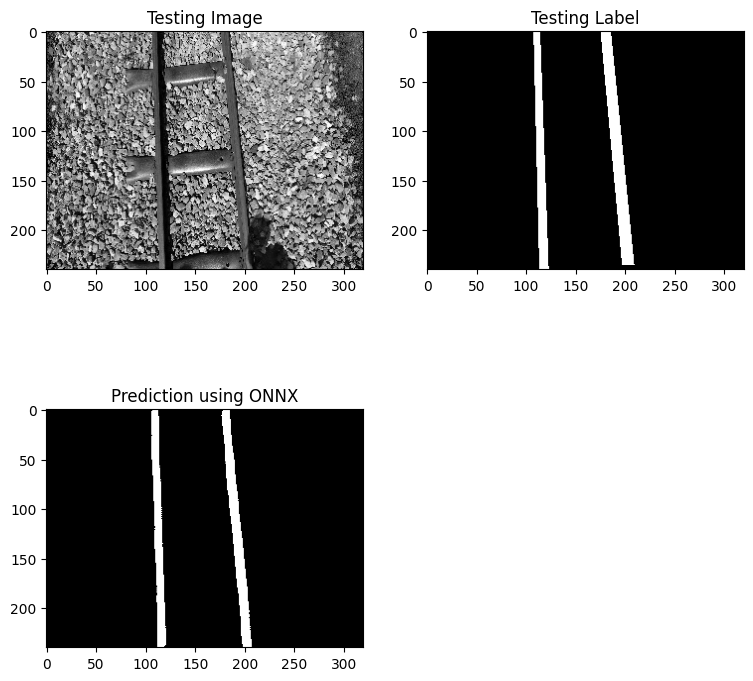

In [ ]:
# ONNX RUNTIME CONVERSION
!pip install onnxruntime
import onnxruntime

input_tensor = onnx_model.graph.input[0]
input_shape = input_tensor.type.tensor_type.shape
input_shape.dim[3].dim_value = 3

session = onnxruntime.InferenceSession("model3.onnx")# creates inference session

(session.get_inputs()[0].shape)#unk 8 name of the first dimension
print(session.get_inputs()[0].type)

input_name = session.get_inputs()[0].name
print(input_name)

output_name=session.get_outputs()[0].name
print(output_name)

# print(len(X_test))

test_img_number = random.randint(0,len(X_test))
# print(test_img_number)

test_img = X_test[test_img_number]
# print(test_img.shape)

ground_truth = y_test[test_img_number]

# test_img_norm = test_img[:,:,0][:,:,0]
# print(test_img_norm.shape)

test_img_in = np.expand_dims(test_img,0)
# print(test_img_in.shape)

test_img_in_float = test_img_in.astype(np.float32)
# print(test_img_in_float)


result = session.run([output_name],{input_name: test_img_in_float})

segmented = (result[0][0,:,:,0] >0.5).astype(np.uint8)



plt.figure(figsize=(9, 9))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(223)
plt.title('Prediction using ONNX')
plt.imshow(segmented, cmap='gray')


plt.show()



In [ ]:
# VIDEO SEGMENTATION
#reading cts. and segmented o/p



custom cmap